# LINEAR REGRESSION

## Nội Dung

1. Huấn luyện mô hình Linear Regression trên tập dữ liệu giá nhà (house price dataset). Xử lý dữ liệu thiếu.
2. So sánh hiệu năng khi chuẩn hóa và không chuẩn hóa đầu vào (standardization).
3. Huấn luyện dữ liệu trên các mô hình: Lasso, Ridge, ElasticNet Regression.
4. Xử lý các feature có phân bố lệch (data skewness).

## Code

### 1. Chuẩn bị dữ liệu

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.special as sps
import scipy.stats as stats
import seaborn as sns
import sklearn.model_selection as model_selection

from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
df = pd.read_csv('data/house_price.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df = df.drop(['Id'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [5]:
# Define a function to check for missing data in a DataFrame
def check_nan_df(df):
    miss = df.isna().sum()
    miss = miss[miss > 0]
    print(f'''Danh sách các cột thiếu dữ liệu:
{miss}

Số lượng cột có dữ liệu thiếu: {len(miss)}''')
    return miss

In [6]:
miss = check_nan_df(df)

Danh sách các cột thiếu dữ liệu:
LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

Số lượng cột có dữ liệu thiếu: 19


#### 1.1 Loại bỏ dữ liệu khuyết

In [7]:
cols_to_drop = list(miss[miss > len(df) // 2].index)
cols_to_drop

['Alley', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature']

In [8]:
df.drop(columns=cols_to_drop, inplace=True)
miss = check_nan_df(df)

Danh sách các cột thiếu dữ liệu:
LotFrontage     259
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
FireplaceQu     690
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64

Số lượng cột có dữ liệu thiếu: 14


#### 1.2 Xử lý dữ liệu khuyết

In [9]:
na_list = [i for i in miss.index if i.startswith('Bsmt') or i.startswith('Garage')]
na_list.remove('GarageYrBlt')

print(na_list)

['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']


In [10]:
for na_type in na_list:
    if df[na_type].dtype == 'object':
        df[na_type].mask(df[na_type].isna(), 'NA', inplace=True)
        print(f'{na_type} (kiểu loại): đã điền giá trị NA cho dữ liệu thiếu.')
    else:
        df[na_type].mask(df[na_type].isna(), 0, inplace=True)
        print(f'{na_type} (kiểu số): đã điền giá trị 0 cho dữ liệu thiếu.')

BsmtQual (kiểu loại): đã điền giá trị NA cho dữ liệu thiếu.
BsmtCond (kiểu loại): đã điền giá trị NA cho dữ liệu thiếu.
BsmtExposure (kiểu loại): đã điền giá trị NA cho dữ liệu thiếu.
BsmtFinType1 (kiểu loại): đã điền giá trị NA cho dữ liệu thiếu.
BsmtFinType2 (kiểu loại): đã điền giá trị NA cho dữ liệu thiếu.
GarageType (kiểu loại): đã điền giá trị NA cho dữ liệu thiếu.
GarageFinish (kiểu loại): đã điền giá trị NA cho dữ liệu thiếu.
GarageQual (kiểu loại): đã điền giá trị NA cho dữ liệu thiếu.
GarageCond (kiểu loại): đã điền giá trị NA cho dữ liệu thiếu.


<Axes: ylabel='Frequency'>

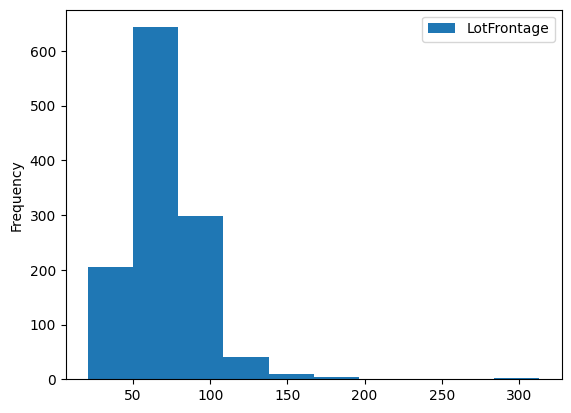

In [11]:
df.loc[~pd.isna(df['LotFrontage']), ['LotFrontage']].plot(kind='hist')

In [12]:
df.loc[pd.isna(df['LotFrontage']), ['LotFrontage']] = np.nanmedian(df['LotFrontage'])
df['LotFrontage'].isnull().values.any()

False

In [13]:
df.loc[pd.isna(df['MasVnrArea']), ['MasVnrArea']] = np.nanmedian(df['MasVnrArea'])
df['MasVnrArea'].isnull().values.any()

False

In [14]:
df.loc[pd.isna(df['GarageYrBlt']), ['GarageYrBlt']] = np.nanmedian(df['GarageYrBlt'])
df['GarageYrBlt'].isnull().values.any()

False

In [15]:
print(f'len dataframe before drop: {len(df)}')
df = df[df['Electrical'].notna()]
print(f'len dataframe after drop {len(df)}')

df['Electrical'].isnull().values.any()

len dataframe before drop: 1460
len dataframe after drop 1459


False

In [16]:
df.loc[df.FireplaceQu.isna(), ['FireplaceQu']].head()

,FireplaceQu
0,NaN
5,NaN
10,NaN
12,NaN
15,NaN


In [17]:
df['FireplaceQu'] = df['FireplaceQu'].mask(df['FireplaceQu'].isna() == True, 'NA')
df['FireplaceQu'].isnull().values.any()

False

In [18]:
df_simple = df.copy()

In [19]:
print(f'Dữ liệu còn thiếu: {np.sum(df_simple.isna().sum())}')

Dữ liệu còn thiếu: 0


### 2. Encoding

In [20]:
object_feats = df_simple.select_dtypes(include=['object']).columns
object_feats

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

#### 2.1 Encode kiểu object về kiểu số

In [21]:
cols = ['ExterQual', 'ExterCond','HeatingQC', 'KitchenQual']
df_simple[cols].head()

,ExterQual,ExterCond,HeatingQC,KitchenQual
0,Gd,TA,Ex,Gd
1,TA,TA,Ex,TA
2,Gd,TA,Ex,Gd
3,TA,TA,Gd,Gd
4,Gd,TA,Ex,Gd


In [22]:
order = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
order_dict = dict(zip(order, np.arange(len(order))[::-1] + 1))
order_dict

{'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}

In [23]:
df_simple[cols] = df_simple[cols].applymap(order_dict.get)
df_simple[cols].isnull().values.any()

False

In [24]:
cols = ['BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageQual', 'GarageCond']
order = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']

df_simple[cols] = df_simple[cols].applymap(dict(zip(order, np.arange(len(order))[::-1] + 1)).get)
df_simple[cols].isnull().values.any()

False

In [25]:
order = ['Gd', 'Av', 'Mn', 'No', 'NA']
df_simple['BsmtExposure'] = df_simple['BsmtExposure'].map(dict(zip(order, np.arange(len(order))[::-1] + 1)))
df_simple[['BsmtExposure']].isnull().values.any()

False

In [26]:
cols = ['BsmtFinType1', 'BsmtFinType2']
order = ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA']

df_simple[cols] = df_simple[cols].applymap(dict(zip(order, np.arange(len(order))[::-1] + 1)).get)
df_simple[cols].isnull().values.any()

False

In [27]:
order = ['Fin', 'RFn', 'Unf', 'NA']
df_simple['GarageFinish'] = df_simple['GarageFinish'].map(dict(zip(order, np.arange(len(order))[::-1] + 1)))
df_simple[['GarageFinish']].isnull().values.any()

False

#### 2.2 Encode 1 hot

In [28]:
df_simple_1hot = pd.get_dummies(df_simple.copy())

In [29]:
df_simple_1hot.shape

(1459, 226)

### 3. Huấn luyện mô hình

#### 3.1 Linear regression - v0

+ Huấn luyện mô hình dựa trên dataframe đã encoding object data, mà chưa qua chuẩn hóa (normalize)
+ Chia tập dữ liệu thành train và test dựa trên thư viện train_test_split sklearn
+ Huấn luyện mô hình Linear Regression dựa trên thư viện LinearRegression của sklearn

In [30]:
X = df_simple_1hot.drop(['SalePrice'], axis=1).to_numpy()
y = df_simple_1hot['SalePrice'].to_numpy()

In [31]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.3, random_state=99)

In [32]:
print(X_train.shape, X_test.shape)

(1021, 225) (438, 225)


In [33]:
print(y_train.shape, y_test.shape)

(1021,) (438,)


In [34]:
# Function to train a model, print the R^2 score, and plot true vs predicted values
def train_model(X, y, model):
    model.fit(X, y)
    score = model.score(X, y)
    pred = model.predict(X)
    print(f'Training set score: {score:.4f}')
    pd.DataFrame({'True values': y, 'Predicted values': pred}).plot.scatter(x='True values', y='Predicted values')
    
    return model, score

In [35]:
linear_regression_v0 = LinearRegression()

Training set score: 0.9297


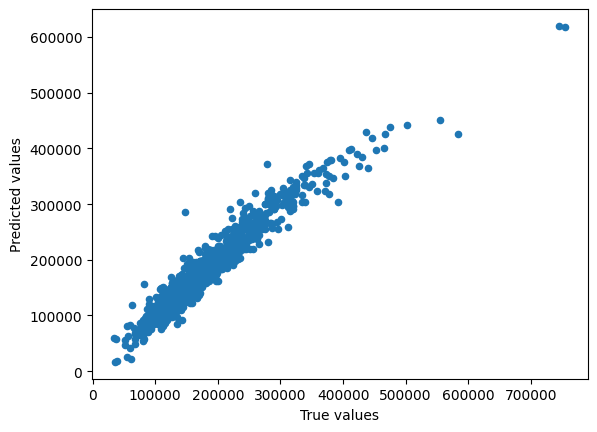

In [36]:
linear_regression_v0, train_score_v0 = train_model(X_train, y_train, linear_regression_v0)

In [37]:
test_score_v0 = linear_regression_v0.score(X_test, y_test)
test_score_v0

0.6650345174103451

In [38]:
X_test[0]

array([60, 89.0, 11645, 7, 5, 2004, 2004, 0.0, 4, 3, 5, 4, 2, 2, 0, 2, 0,
       860, 860, 5, 860, 860, 0, 1720, 0, 0, 2, 1, 3, 1, 4, 7, 0, 1,
       2004.0, 3, 2, 565, 4, 4, 0, 70, 0, 0, 0, 0, 0, 8, 2006, False,
       False, False, True, False, False, True, True, False, False, False,
       False, False, False, True, True, False, True, False, False, False,
       False, True, False, False, False, False, False, False, False, True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, True, False, False, False, False, False,
       False, False, False, True, False, False, False, False, False, True,
       False, False, False, False, False, False, False, False, False,
       True, False, False, False, True, False, False, False, False, False,
       True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, Fal

In [39]:
np.shape(X_test[0].reshape(1, -1))

(1, 225)

In [40]:
linear_regression_v0.predict(X_test[0].reshape(1, -1))

array([193662.17005023])

In [41]:
y_test[0]

196500

In [42]:
encoded_df = df.copy()

for sample in df.select_dtypes(include=['object']).columns:
    num_unique_values = encoded_df[sample].nunique()

    if num_unique_values > 2:
        encoded_df[sample] = LabelEncoder().fit_transform(encoded_df[sample])
    else:
        ohe = OneHotEncoder()
        encoded_df = pd.concat([encoded_df, pd.DataFrame(ohe.fit_transform(encoded_df[[sample]]).toarray(), columns=[f'{sample}_{feature}' for feature in ohe.get_feature_names_out()])], axis=1)
        encoded_df.drop(sample, axis=1, inplace=True)

In [43]:
encoded_df = encoded_df.dropna()

In [44]:
X = encoded_df.drop(['SalePrice'], axis=1).to_numpy()
y = encoded_df['SalePrice'].to_numpy()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.3, random_state=99)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1020, 79) (438, 79)
(1020,) (438,)


Training set score: 0.8469


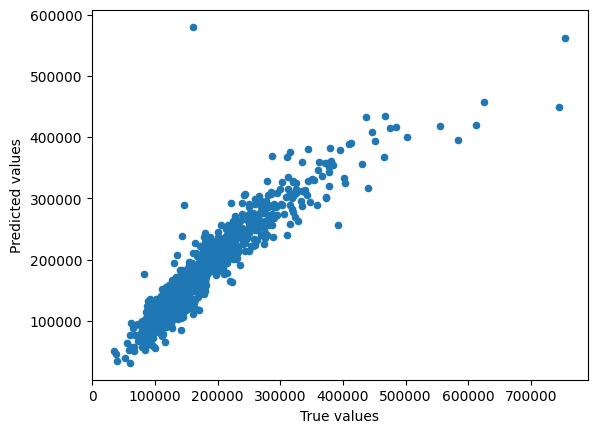

In [45]:
linear_regression_v0 = LinearRegression()
linear_regression_v0, train_score_v0 = train_model(X_train, y_train, linear_regression_v0)

In [46]:
test_score_v0 = linear_regression_v0.score(X_test, y_test)
test_score_v0

0.8312396844564336

In [47]:
X_test[0]

array([6.0000e+01, 3.0000e+00, 8.9000e+01, 1.1645e+04, 0.0000e+00,
       3.0000e+00, 0.0000e+00, 0.0000e+00, 5.0000e+00, 2.0000e+00,
       2.0000e+00, 0.0000e+00, 5.0000e+00, 7.0000e+00, 5.0000e+00,
       2.0040e+03, 2.0040e+03, 1.0000e+00, 1.0000e+00, 1.2000e+01,
       1.3000e+01, 0.0000e+00, 2.0000e+00, 4.0000e+00, 2.0000e+00,
       2.0000e+00, 4.0000e+00, 4.0000e+00, 6.0000e+00, 0.0000e+00,
       6.0000e+00, 0.0000e+00, 8.6000e+02, 8.6000e+02, 1.0000e+00,
       0.0000e+00, 4.0000e+00, 8.6000e+02, 8.6000e+02, 0.0000e+00,
       1.7200e+03, 0.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00,
       3.0000e+00, 1.0000e+00, 2.0000e+00, 7.0000e+00, 6.0000e+00,
       0.0000e+00, 3.0000e+00, 1.0000e+00, 2.0040e+03, 2.0000e+00,
       2.0000e+00, 5.6500e+02, 5.0000e+00, 5.0000e+00, 2.0000e+00,
       0.0000e+00, 7.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 8.0000e+00, 2.0060e+03, 8.0000e+00,
       4.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e

In [48]:
np.shape(X_test[0].reshape(1, -1))

(1, 79)

In [49]:
linear_regression_v0.predict(X_test[0].reshape(1, -1))

array([197158.63994436])

In [50]:
y_test[0]

196500.0

#### 3.2 Linear regression + xử lý đặc trưng có phân bố lệch - v1

In [51]:
# Function to apply ordinal encoding to specified columns in a DataFrame
def ordinal_encode(df, cols, order):
    df[cols] = df[cols].applymap(dict(zip(order, np.arange(len(order))[::-1] + 1)).get)
    df[cols].isnull().values.any()

    return df

##### 3.2.1 Skewness

In [52]:
df_simple = df.copy()

In [53]:
# Function to calculate the skewness of a DataFrame column
def calc_skew(df_col):
    return stats.skew(df_col)

In [54]:
numeric_feats = df_simple.select_dtypes(include=[np.number]).columns

In [55]:
skewed_feats = df_simple[numeric_feats].apply(calc_skew).sort_values(ascending=False)
skewed_feats

MiscVal          24.443278
PoolArea         14.807992
LotArea          12.190881
3SsnPorch        10.290132
LowQualFinSF      8.998885
KitchenAbvGr      4.482026
BsmtFinSF2        4.249219
ScreenPorch       4.116334
BsmtHalfBath      4.097541
EnclosedPorch     3.085342
MasVnrArea        2.673798
LotFrontage       2.406187
OpenPorchSF       2.361099
SalePrice         1.880008
BsmtFinSF1        1.683465
WoodDeckSF        1.539362
TotalBsmtSF       1.525190
MSSubClass        1.407171
1stFlrSF          1.375089
GrLivArea         1.364297
BsmtUnfSF         0.918367
2ndFlrSF          0.813466
OverallCond       0.691340
HalfBath          0.677275
TotRmsAbvGrd      0.676068
Fireplaces        0.647913
BsmtFullBath      0.594354
OverallQual       0.215497
BedroomAbvGr      0.211839
MoSold            0.210889
GarageArea        0.179081
YrSold            0.096422
FullBath          0.037821
GarageCars       -0.341494
YearRemodAdd     -0.502108
YearBuilt        -0.612133
GarageYrBlt      -0.677085
d

In [56]:
print('Skew in numerical features:')
skewness = pd.DataFrame({'Skew': df_simple[numeric_feats].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)})
skewness

Skew in numerical features:


,Skew
MiscVal,24.443278
PoolArea,14.807992
LotArea,12.190881
3SsnPorch,10.290132
LowQualFinSF,8.998885
KitchenAbvGr,4.482026
BsmtFinSF2,4.249219
ScreenPorch,4.116334
BsmtHalfBath,4.097541
EnclosedPorch,3.085342


In [57]:
LAM = .15

In [58]:
for feat in skewness.index:
    if abs(skewness.loc[feat]['Skew']) > .75:
        df_simple[feat] = sps.boxcox1p(df_simple[feat], LAM)

In [59]:
cols = ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual']
order = ['Ex', 'Gd', 'TA', 'Fa', 'Po']

cols_1 = ['BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageQual', 'GarageCond']
order_1 = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']

cols_2 = ['BsmtExposure']
order_2 = ['Gd', 'Av', 'Mn', 'No', 'NA']

cols_3 = ['BsmtFinType1', 'BsmtFinType2']
order_3 = ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA']

cols_4 = ['GarageFinish']
order_4 = ['Fin', 'RFn', 'Unf', 'NA']

df_simple = ordinal_encode(df_simple, cols, order)
df_simple = ordinal_encode(df_simple, cols_1, order_1)
df_simple = ordinal_encode(df_simple, cols_2, order_2)
df_simple = ordinal_encode(df_simple, cols_3, order_3)
df_simple = ordinal_encode(df_simple, cols_4, order_4)

df_simple.shape

(1459, 75)

In [60]:
df_simple[['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond']].isnull().values.any()

False

In [61]:
df_simple_1hot = pd.get_dummies(df_simple)
df_simple_1hot.shape

(1459, 226)

##### 3.2.2 Chia train/test

In [62]:
X = df_simple_1hot.drop(['SalePrice'], axis=1).to_numpy()
y = df_simple_1hot['SalePrice'].to_numpy()

In [63]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.3, random_state=99)

##### 3.2.3 Huấn luyện

In [64]:
linear_regression_v1 = LinearRegression()

Training set score: 0.9502


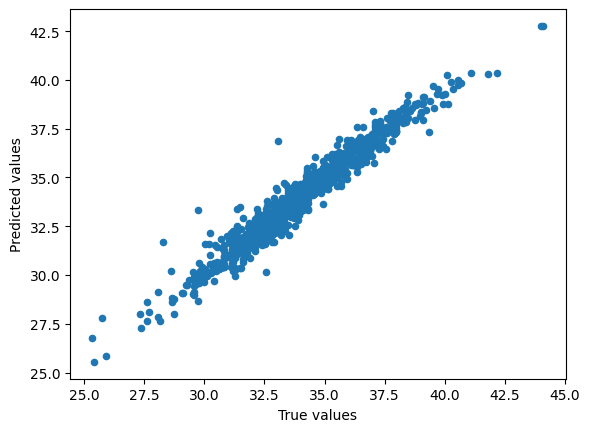

In [65]:
linear_regression_v1, train_score_v1 = train_model(X_train, y_train, linear_regression_v1)

In [66]:
test_score_v1 = linear_regression_v1.score(X_test, y_test)
test_score_v1

0.8303924848073256

In [67]:
print(y_test[0])
linear_regression_v1.predict(X_test[0].reshape(1, -1))

34.820469395807066


array([34.82275382])

##### 3.2.4 Khảo sát hệ số của mô hình

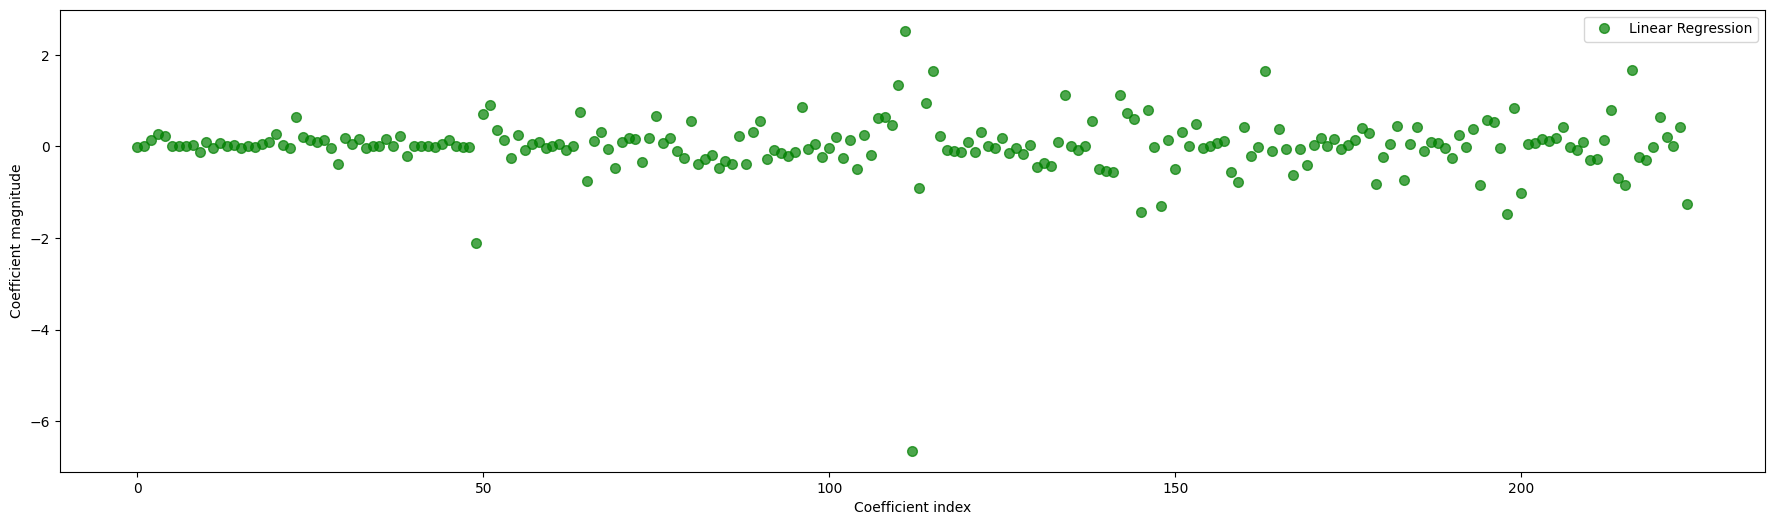

In [68]:
_, ax = plt.subplots(1, figsize=(22, 6))
ax.plot(linear_regression_v1.coef_, alpha=.7, linestyle='none', marker='o', markersize=7, color='g', label='Linear Regression')
plt.xlabel('Coefficient index')
plt.ylabel('Coefficient magnitude')
plt.legend()

In [69]:
min_ind = np.argmin(linear_regression_v1.coef_)
min_ind

112

In [70]:
df_simple_1hot.columns[min_ind]

'Condition2_PosA'

In [71]:
linear_regression_v1.coef_[min_ind]

-6.646064543527871

In [72]:
df_simple_1hot['Condition2_PosA']

0       False
1       False
2       False
3       False
4       False
        ...  
1455    False
1456    False
1457    False
1458    False
1459    False
Name: Condition2_PosA, Length: 1459, dtype: bool

In [73]:
list(df_simple_1hot.columns).index('GrLivArea')

23

In [74]:
linear_regression_v1.coef_[23]

0.6469755186545342

In [75]:
np.max(X[:, 23])

17.690975636691796

In [76]:
np.min(X[:, 23])

9.279836446808169

In [77]:
df['GrLivArea']

0       1710
1       1262
2       1786
3       1717
4       2198
        ... 
1455    1647
1456    2073
1457    2340
1458    1078
1459    1256
Name: GrLivArea, Length: 1459, dtype: int64

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

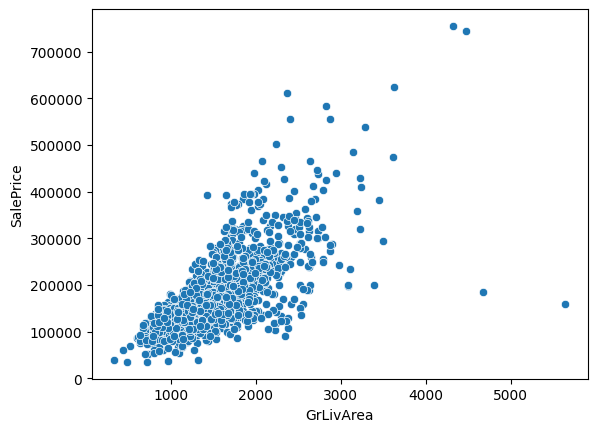

In [78]:
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df)

#### 3.3 Lasso + xử lý đặc trưng có phân bố lệch - v2

##### 3.3.1 Huấn luyện

Training set score: 0.6579
Test score:  0.6656184075449938
Training set score: 0.8797
Test score:  0.8499297666332137
Training set score: 0.9162
Test score:  0.865660036742785
Training set score: 0.9458
Test score:  0.8478878181076155


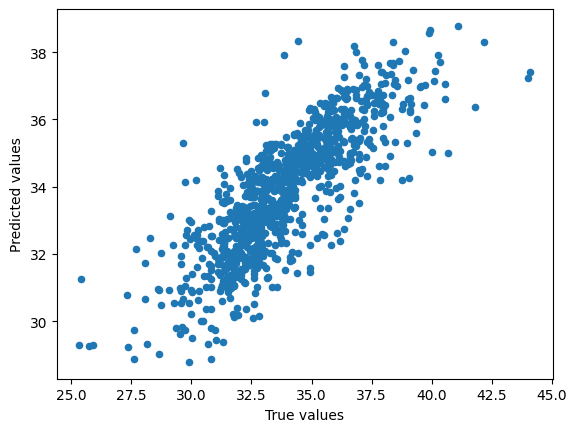

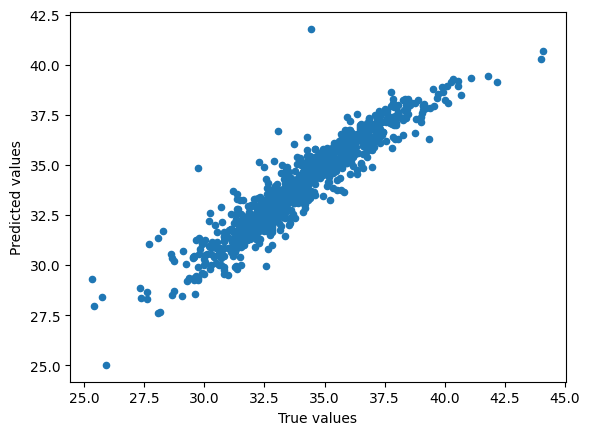

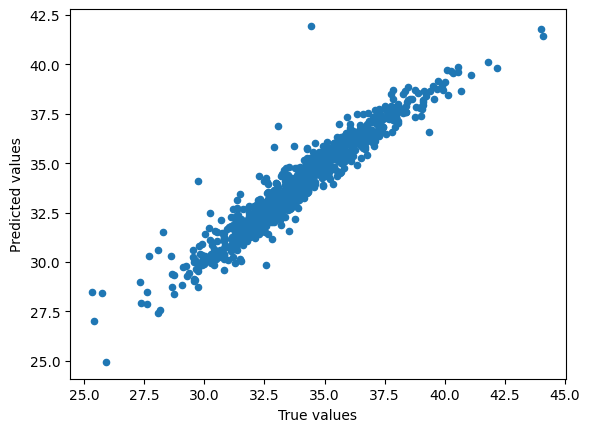

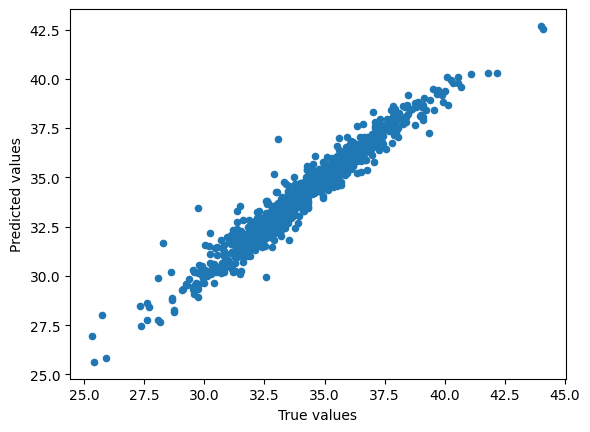

In [79]:
lassos = []
alphas = [1, .1, .01, .001]

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso, _ = train_model(X_train, y_train, lasso)
    lassos.append(lasso)
    print('Test score: ', lasso.score(X_test, y_test))

In [80]:
print(y_test[15])
lassos[2].predict(X_test[15].reshape(1, -1))

31.83809786337166


array([31.54915316])

In [81]:
linear_regression_v1.score(X_test, y_test)

0.8303924848073256

In [82]:
print(y_test[15])
linear_regression_v1.predict(X_test[15].reshape(1, -1))

31.83809786337166


array([31.80863307])

##### 3.3.2 Khảo sát tham số của mô hình

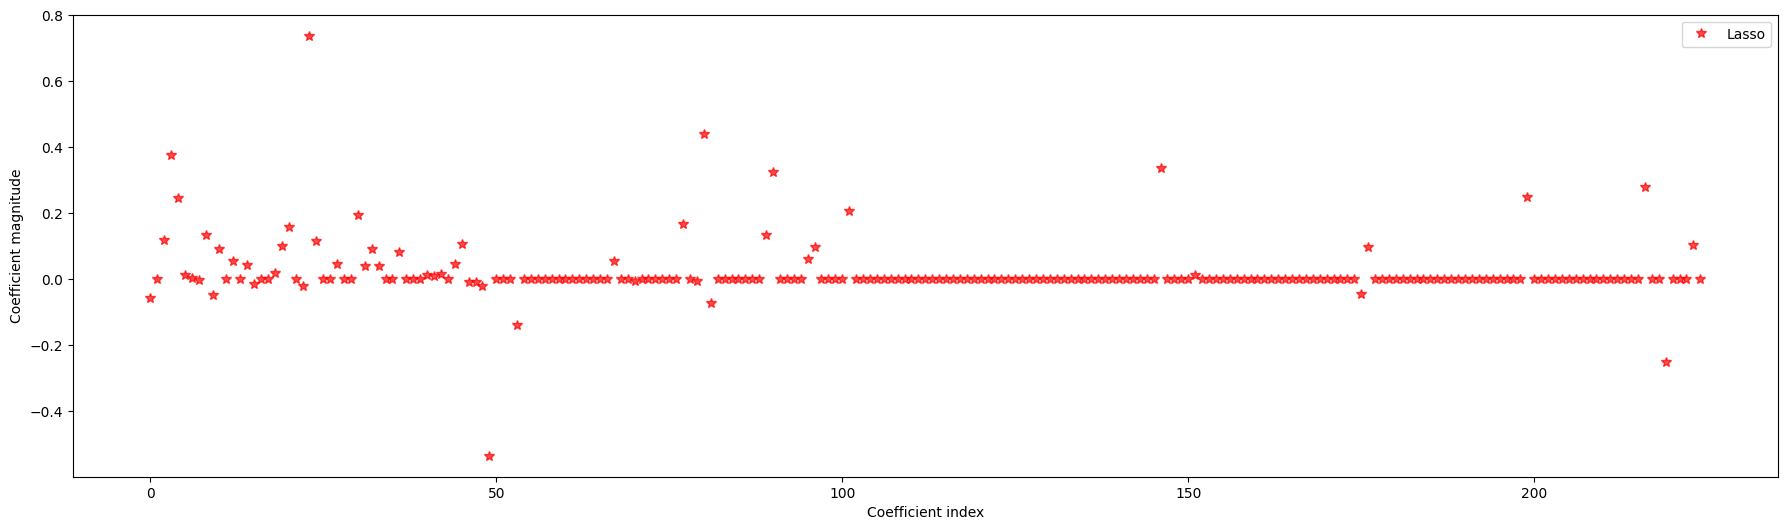

In [83]:
_, ax = plt.subplots(1, figsize=(22, 6))
ax.plot(lassos[2].coef_, alpha=.7, linestyle='none', marker='*', markersize=7, color='r', label='Lasso')
plt.xlabel('Coefficient index')
plt.ylabel('Coefficient magnitude')
plt.legend()

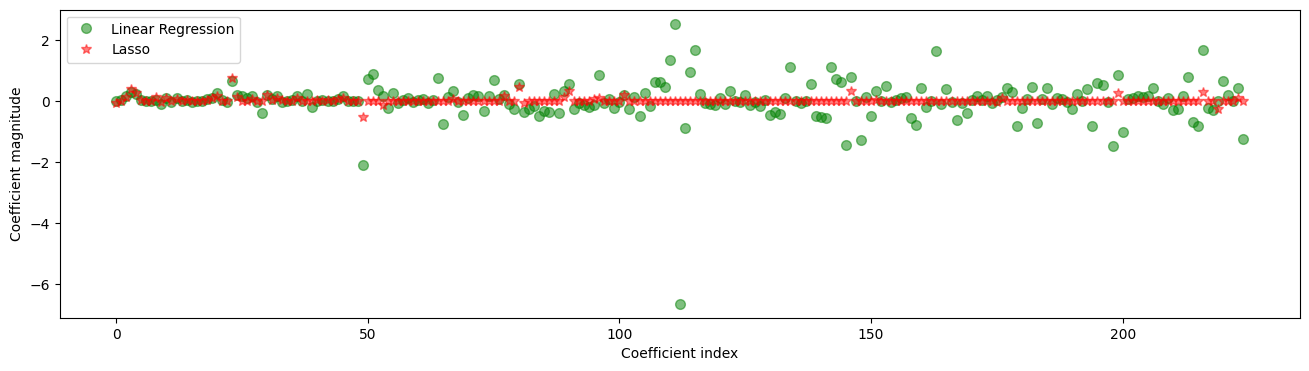

In [84]:
_, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(linear_regression_v1.coef_, alpha=.5, linestyle='none', marker='o', markersize=7, color='g', label='Linear Regression')
ax.plot(lassos[2].coef_, alpha=.5, linestyle='none', marker='*', markersize=7, color='r', label='Lasso')
plt.xlabel('Coefficient index')
plt.ylabel('Coefficient magnitude')
plt.legend()

In [85]:
lassos[2].coef_[lassos[2].coef_ == 0].shape

(167,)

In [86]:
max_ind = np.argmax(linear_regression_v1.coef_)
df_simple_1hot.columns[max_ind]

'Condition2_Norm'

In [87]:
linear_regression_v1.coef_[max_ind]

2.5258040744627217

In [88]:
lassos[2].coef_[max_ind]

0.0

In [89]:
max_ind = np.argmax(lassos[2].coef_)
df_simple_1hot.columns[max_ind]

'GrLivArea'

In [90]:
print(linear_regression_v1.coef_[max_ind])
print(lassos[2].coef_[max_ind])

0.6469755186545342
0.7372924267835584


In [91]:
lassos[2].coef_[lassos[2].coef_ < .001].shape

(186,)

In [92]:
np.argmax(lassos[2].coef_)

23

In [93]:
lassos[2].coef_[23]

0.7372924267835584

In [94]:
np.argmin(lassos[2].coef_)

49

#### 3.4 Ridge + xử lý đặc trưng có phân bố lệch - v3

##### 3.4.1 Huấn luyện

In [95]:
alphas = [10, 1, .1, .01, .001, .0001]

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    print(f'alpha = {alpha}\tTrain score: {ridge.score(X_train, y_train)}\tTest score: {ridge.score(X_test, y_test)}')

alpha = 10	Train score: 0.9354213819921805	Test score: 0.8619794279607406
alpha = 1	Train score: 0.9467779470153057	Test score: 0.8514271667242931
alpha = 0.1	Train score: 0.9500460881504812	Test score: 0.8358816787073553
alpha = 0.01	Train score: 0.9501980407761476	Test score: 0.8310517734827929
alpha = 0.001	Train score: 0.9502000904663703	Test score: 0.8304597915999049
alpha = 0.0001	Train score: 0.95020011169245	Test score: 0.8303992296248519


##### 3.4.2 Huấn luyện trên dữ liệu chuẩn hóa

In [96]:
ridge = Ridge(alpha=10)
ridge = ridge.fit(X_train, y_train)

In [97]:
np.unique(ridge.coef_ == 0, return_counts=True)

(array([False,  True]), array([223,   2], dtype=int64))

In [98]:
np.unique(lassos[2].coef_ == 0, return_counts=True)

(array([False,  True]), array([ 58, 167], dtype=int64))

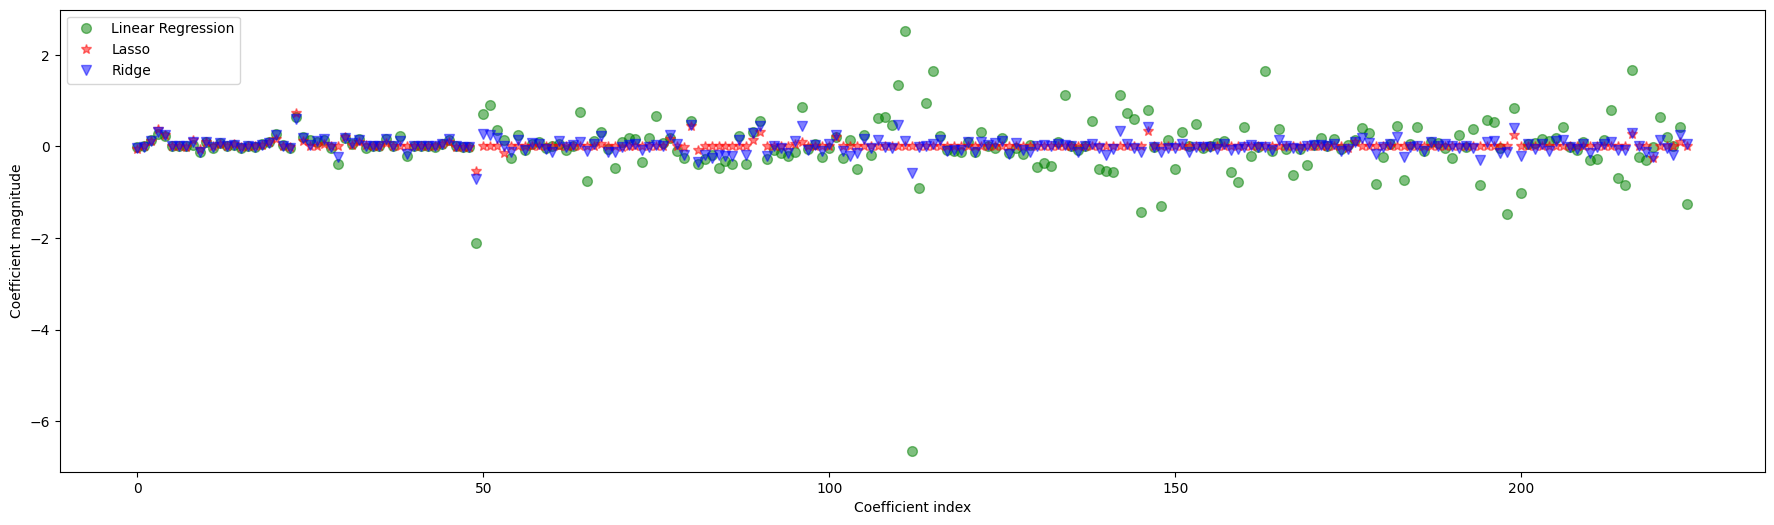

In [99]:
_, ax = plt.subplots(1, figsize=(22, 6))
ax.plot(linear_regression_v1.coef_, alpha=.5, linestyle='none', marker='o', markersize=7, color='g', label='Linear Regression')
ax.plot(lassos[2].coef_, alpha=.5, linestyle='none', marker='*', markersize=7, color='r', label='Lasso')
ax.plot(ridge.coef_, alpha=.5, linestyle='none', marker='v', markersize=7, color='b', label='Ridge')
plt.xlabel('Coefficient index')
plt.ylabel('Coefficient magnitude')
plt.legend()

#### 3.5 ElasticNet + xử lý đặc trưng có phân bố lệch - v4

In [100]:
alphas = [1, .1, .01, .001, .0001]
l1_ratios = np.linspace(0, 1, 11)[1:-1]

for alpha in alphas:
    for l1 in l1_ratios:
        elastic = ElasticNet(alpha=alpha, l1_ratio=l1, max_iter=10000)
        elastic.fit(X_train, y_train)
        print(f'alpha = {alpha}\tl1 = {round(l1, 2)}\tTrain score: {elastic.score(X_train, y_train)}\tTest score: {elastic.score(X_test, y_test)}')

alpha = 1	l1 = 0.1	Train score: 0.8533815949562609	Test score: 0.8234667236341437
alpha = 1	l1 = 0.2	Train score: 0.8360720107243058	Test score: 0.8120271485013075
alpha = 1	l1 = 0.3	Train score: 0.8209691621464332	Test score: 0.8018601761946854
alpha = 1	l1 = 0.4	Train score: 0.8024398177086579	Test score: 0.7884016704800237
alpha = 1	l1 = 0.5	Train score: 0.7827035536746124	Test score: 0.7729466665652669
alpha = 1	l1 = 0.6	Train score: 0.7632878225941644	Test score: 0.7568360963030663
alpha = 1	l1 = 0.7	Train score: 0.7400899353322167	Test score: 0.737047662413122
alpha = 1	l1 = 0.8	Train score: 0.7123059987213689	Test score: 0.7126987821696812
alpha = 1	l1 = 0.9	Train score: 0.6804792186694689	Test score: 0.6846326800532236
alpha = 0.1	l1 = 0.1	Train score: 0.9037854872996844	Test score: 0.8556384992114426
alpha = 0.1	l1 = 0.2	Train score: 0.8965007463347151	Test score: 0.8517471084340029
alpha = 0.1	l1 = 0.3	Train score: 0.8919787459638147	Test score: 0.8509034137613447
alpha = 0.1

alpha = 0.001	l1 = 0.4	Train score: 0.9463378126097544	Test score: 0.854631016435589
alpha = 0.001	l1 = 0.5	Train score: 0.9462331706411208	Test score: 0.8546134048870437
alpha = 0.001	l1 = 0.6	Train score: 0.9461323850692719	Test score: 0.8542185703616181
alpha = 0.001	l1 = 0.7	Train score: 0.9460497741064319	Test score: 0.8534624731376348
alpha = 0.001	l1 = 0.8	Train score: 0.9459863222513181	Test score: 0.8522834480631692
alpha = 0.001	l1 = 0.9	Train score: 0.9459049284862834	Test score: 0.8505668524006993
alpha = 0.0001	l1 = 0.1	Train score: 0.9500483228439234	Test score: 0.8360578856493759
alpha = 0.0001	l1 = 0.2	Train score: 0.9500547036767388	Test score: 0.8361666397169445
alpha = 0.0001	l1 = 0.3	Train score: 0.9500595383970876	Test score: 0.8363460695040745
alpha = 0.0001	l1 = 0.4	Train score: 0.9500623891260681	Test score: 0.8360892073113164
alpha = 0.0001	l1 = 0.5	Train score: 0.9500644907605816	Test score: 0.8357813033659193
alpha = 0.0001	l1 = 0.6	Train score: 0.95006393569

In [101]:
grid_search = GridSearchCV(ElasticNet(max_iter=10000), {'alpha': [1, .1, .01, .001, .0001], 'l1_ratio': np.linspace(0, 1, 11)[1:-1]}, cv=5, scoring='r2', return_train_score=True)
grid_search.fit(X_train, y_train)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')
print(f'Test score of the best model: {grid_search.best_estimator_.score(X_test, y_test)}')

Best parameters: {'alpha': 0.001, 'l1_ratio': 0.8}
Best score: 0.9031251725263006
Test score of the best model: 0.8522834480631692


### 4. Nhiễu

In [102]:
df = pd.read_csv('data/house_price.csv')

In [103]:
df = df.drop(['Id'], axis=1)

In [104]:
miss = df.isna().sum()
miss = miss[miss > 0]
df_simple = df.drop(miss.index, axis=1)

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

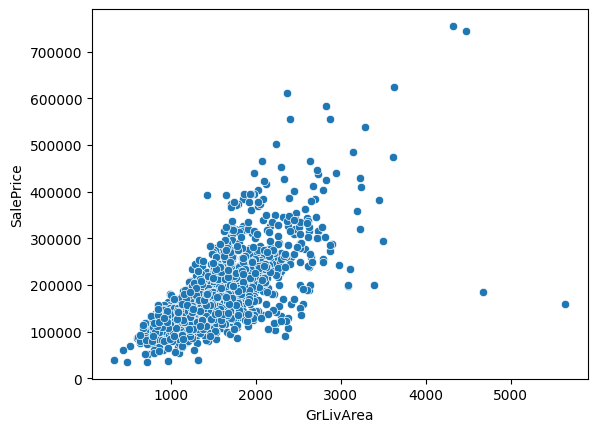

In [105]:
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df_simple)

In [106]:
df_simple[df_simple['GrLivArea'] > 4500]

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,...,0,0,0,0,0,10,2007,New,Partial,184750
1298,60,RL,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,Edwards,...,0,0,0,480,0,1,2008,New,Partial,160000


In [107]:
df_simple = df_simple.drop(df_simple[df_simple['GrLivArea'] > 4500].index, axis=0)

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

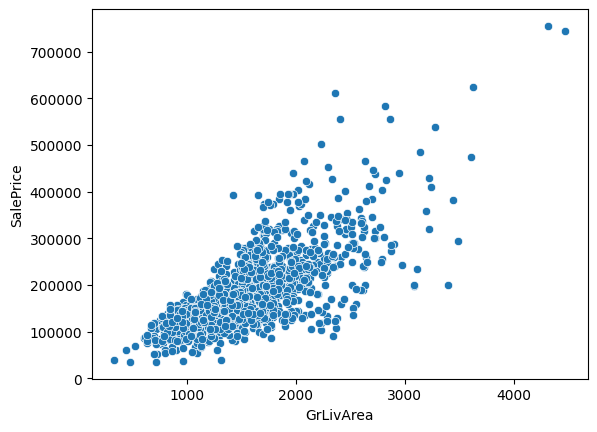

In [108]:
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df_simple)

In [109]:
df_simple['GrLivArea'].skew()

1.0109917025385513

In [110]:
for col in ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'Functional', 'LandSlope', 'LotShape', 'PavedDrive', 'Street', 'CentralAir', 'MSSubClass', 'OverallCond']:
    lbl = LabelEncoder()
    lbl.fit(list(df_simple[col].values))
    df_simple[col] = lbl.transform(list(df_simple[col].values))

df_simple.shape

(1458, 61)

In [111]:
df_simple['SalePrice'] = np.log1p(df_simple['SalePrice'])

In [112]:
print('Skew in numerical features:')
skewness = pd.DataFrame({'Skew': df_simple[df_simple.select_dtypes(include=[np.number]).columns].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)})
skewness

Skew in numerical features:


,Skew
MiscVal,24.434913
PoolArea,15.932532
LotArea,12.560986
3SsnPorch,10.286510
LowQualFinSF,8.995688
LandSlope,4.805032
KitchenAbvGr,4.480268
BsmtFinSF2,4.247550
ScreenPorch,4.114690
BsmtHalfBath,4.095895


In [113]:
for feat in skewness.index:
    if abs(skewness.loc[feat]['Skew']) > .75:
        df_simple[feat] = sps.boxcox1p(df_simple[feat], LAM)

In [114]:
df_simple_1hot = pd.get_dummies(df_simple)

In [115]:
X = df_simple_1hot.drop(['SalePrice'], axis=1).to_numpy()
y = df_simple_1hot['SalePrice'].to_numpy()

In [116]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.3, random_state=99)

Training set score: 0.9503


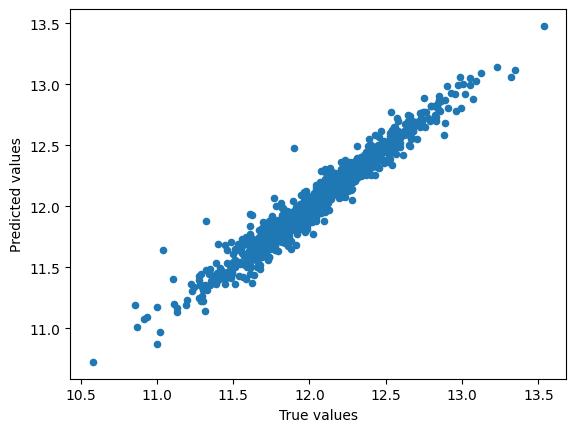

In [117]:
linear_regression = LinearRegression()
linear_regression, train_score = train_model(X_train, y_train, linear_regression)

In [118]:
test_score = linear_regression.score(X_test, y_test)
test_score

0.9060192396397782